$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 5: Control a Marble with Reinforcement Learning

*Sean Russell*

## Overview

Some of the things I've done:

* Support for varying goal state
* Broken up display of graphs into seperate functions
* New methods to display confidence and to visualize the movement of the marble
* Messing with variables to create a good agent for playing this marble game

## Method Definitions

In [1]:
import neuralnetworksbylayer as nn
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import copy

%matplotlib inline

First up are all of the methods that were already defined

In [2]:
validActions = np.array([ -1, 0, 1])

def initialState():
    return np.array([10*np.random.random_sample(), 3*(0.5-np.random.random_sample()),10*np.random.random_sample()])

def nextState(s,a):
    s = copy.copy(s)   # s[0] is position, s[1] is velocity. a is -1, 0 or 1
    deltaT = 0.1                           # Euler integration time step
    s[0] += deltaT * s[1]                  # Update position
    s[1] += deltaT * (2 * a - 0.2 * s[1])  # Update velocity. Includes friction
    if s[0] < 0:        # Bound next position. If at limits, set velocity to 0.
        s = np.array([0,0,s[2]])
    elif s[0] > 10:
        s = np.array([10,0,s[2]])
    return s

def reinforcement(s):  # s is new state
    goal = s[2]
    return 0 if abs(s[0]-goal) < 1 else -0.1

def policy(qnet, state, epsilon):
    if np.random.rand(1) < epsilon:
        actioni = np.random.randint(validActions.shape[0])
    else:
        inputs = np.hstack(( np.tile(state, (validActions.shape[0], 1)), validActions.reshape((-1,1))))
        qs = qnet.use(inputs)
        actioni = np.argmax(qs)
    return validActions[actioni]

def makeSamples(qnet, nStepsPerStart):
    samples = []
    state = initialState()
    act = policy(qnet, state, epsilon)
    oldact = act
    for iStep in range(nStepsPerStart):
        newState = nextState(state, act)
        r = reinforcement(newState)
        newAct = policy(qnet, newState, epsilon)
        # SARSA
        samples.append(state.tolist() + [act, r] + newState.tolist() + [newAct])
        state = newState
        oldact = act
        act = newAct
    return np.array(samples)

Next I redefined the method to plot the path and velocity of the marble on its way to an arbitrary goal.

In [3]:
def generatePathPlot(qnet,nTrials,nStepsPerTrial,goal):
    xs = np.linspace(0,10,nTrials)
    for x in xs:
        s = [x,0,goal] ## 0 velocity
        xtrace = np.zeros((nStepsPerTrial,3))
        for step in range(nStepsPerTrial):
            a = policy(qnet, s, 0.0)  # epsilon = 0
            s = nextState(s,a)
            xtrace[step,:] = s
        plt.plot(xtrace[:,0],xtrace[:,1])
        plt.xlim(-1,11)
        plt.ylim(-5,5)
        plt.plot([goal,goal],[-5,5],'--',alpha=0.5,lw=5)

And I created functions to plot the Q values of the network at given locations. This used to be wrapped up in another function

In [4]:
def plotMaxQ(goal):
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qsmax)
    plt.colorbar(cs)
    plt.xlabel("position")
    plt.ylabel("velocity")
    plt.title("Max Q")

def plotActions(goal):
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    qs = qs.reshape((len(validActions),-1)).T
    acts = np.array(validActions)[np.argmax(qs,axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs,ys,acts,[-2, -0.5, 0.5, 2])
    plt.colorbar(cs)
    plt.xlabel("position")
    plt.ylabel("velocity")
    plt.title("Actions")

def plotFigs(goal):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plotMaxQ(goal)
    plt.subplot(1,2,2)
    plotActions(goal)

And a few methods I cooked up myself. This first one plots the confidence of the network by dividing the Q value of a given action by the sum of Q values for all values, to see how much better the best option is (in the opinion of the neural network).

In [5]:
def confidencePlot(goal):
    plt.figure(figsize=(7,5))
    n = 20
    positions = np.linspace(0,10,n)
    velocities =  np.linspace(-5,5,n)
    xs,ys = np.meshgrid(positions,velocities)
    xsflat = xs.flat
    ysflat = ys.flat

    qs = qnet.use(np.array([[xsflat[i],ysflat[i],goal,a] for a in validActions for i in range(len(xsflat))]))
    qs = qs.reshape((len(validActions),-1)).T
    qsmax = np.max(qs,axis=1)
    qssum = np.sum(qs,axis=1)
    qstot = (qsmax / qssum).reshape(xs.shape)
    cs = plt.contourf(xs,ys,qstot)
    plt.colorbar(cs)
    plt.xlabel("position")
    plt.ylabel("velocity")
    plt.title("confidence")

These two are my favorite. Giving the network a state, these methods animate the movement of the marble to its goal. This really helps visualize how it works, because it is an actual animation of the agent in action.

In [6]:
def plotMarbleState(state):
    plt.axis('off')
    plt.xlim(-1,11)
    plt.ylim(-1,1)
    plt.xlabel('position')
    plt.plot(state[0],0,'o',markersize=20,label='marble')
    plt.plot([state[2],state[2]],[-5,5],'--',alpha=0.5,lw=5,label='goal')
    plt.legend(loc='upper left')

def marbleToDestination(state):
    fig = plt.figure()
    for i in range(100):
        if np.abs(state[0]-state[2]) < .1 or state[0]<=0 or state[0]>=10:
            break
        plt.clf()
        clear_output(wait=True)
        plotMarbleState(state)
        display(fig)
        #plt.pause(0.01)
        action = policy(qnet, state, 0.0)
        state = nextState(state,action)
    clear_output(wait=True)

## Learning the World

The next thing to do is teach the network how the world it lives in works.

So, I did a whole lot of messing around with these variables.

In [7]:
gamma = 0.999
nTrials = 2000
nStepsPerTrial = 500 
nSCGIterations = 30
finalEpsilon = 0.01
nh = [5,5]
epsilonDecay = np.exp(np.log(finalEpsilon)/(nTrials))  # to produce this final value
qnet = nn.NeuralNetwork([4] + nh + [1])  # [4, 5, 5, 1]
qnet.setInputRanges(( (0, 10), (-3, 3), (0,10), (-1,1)))

Even after several hours of messing around, I'm still not certain what values are the best. The main issues with the network are consistency. A lot of the networks will work for goals with low values but screw up with high values, or vice versa, or will only work on goals in the middle, etc. However, every once in a while a network will show up that seems to work properly for most states for the marble.

Increasing nTrials and nStepsPerTrial seemed to offer the most improvements. Messing with the structure of the neural net only seemed to cause problems. Increasing nSCGIterations didn't have any particularly noticeable impact.

The next cell trains the network based off of the settings from above.

In [8]:
#train the network
epsilon = 1
epsilonTrace = np.zeros(nTrials)
rtrace = np.zeros(nTrials)
for trial in range(nTrials):
    # Collect nStepsPerRep samples of X, R, Qn, and Q, and update epsilon
    samples = makeSamples(qnet, nStepsPerTrial)
    numberstates = 3
    numberactions = 1
    X = samples[:, :numberstates+numberactions]
    R = samples[:, numberstates+numberactions:numberstates+numberactions+1]
    nextX = samples[:, numberstates+numberactions+1:]
    nextQ = qnet.use(nextX)
    
    qnet.train(X, R + gamma * nextQ, nIterations = nSCGIterations)

And this cell displays the velocity and position of the marble all along its path to the goal, for every goal state (0-10) and every initial position (0-10)

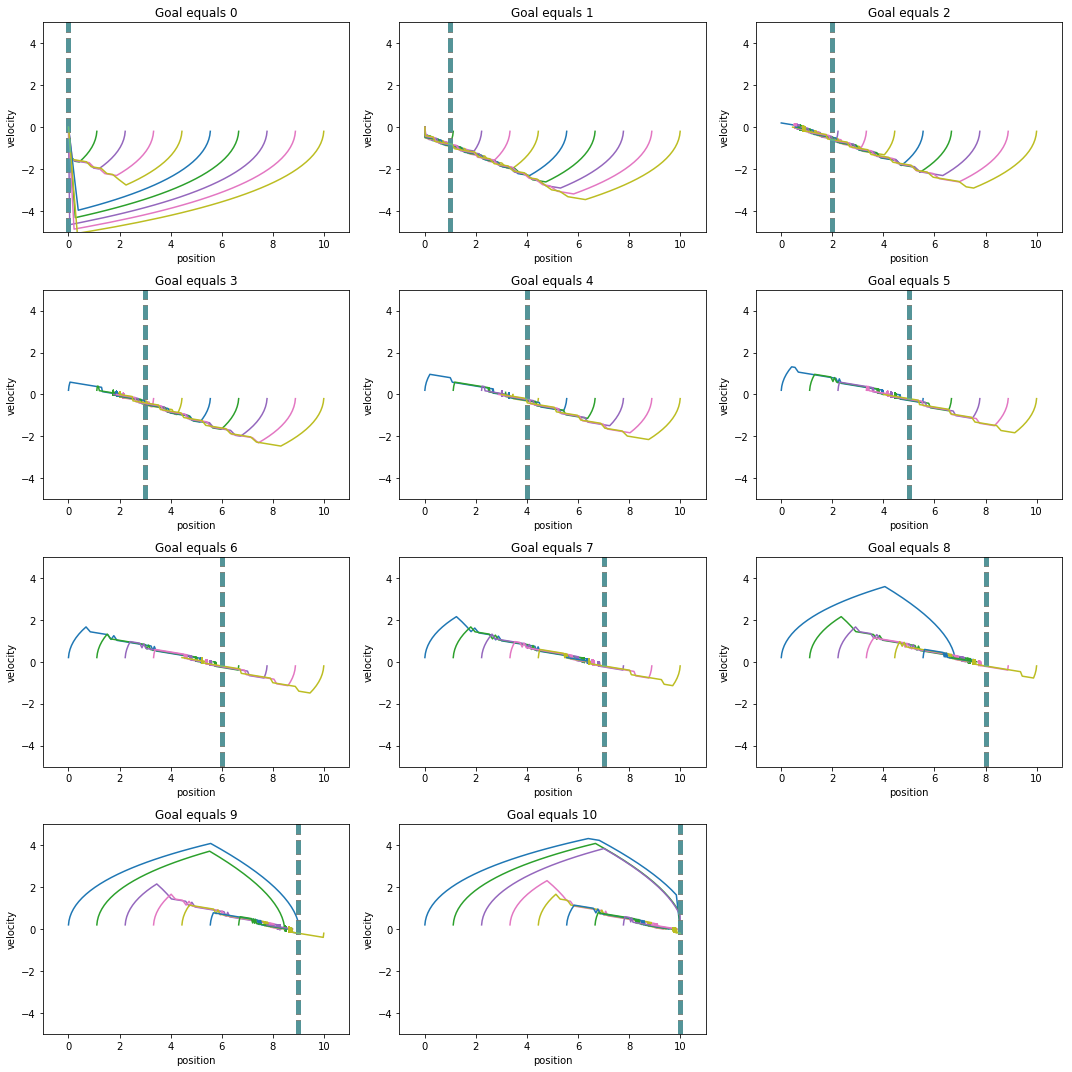

In [9]:
fig = plt.figure(figsize=(15,15))
for goal in range(11):
    plt.subplot(4,3,goal+1)
    generatePathPlot(qnet,10,500,goal)
    plt.xlabel('position')
    plt.ylabel('velocity')
    plt.title('Goal equals ' + str(goal))
    plt.tight_layout()

I think it's interesting that the marble learned to accelerate smoothly, but it decelerates in steps. Every trial I've run it does that, so I think it might be an advantageous strategy, or perhaps it is just an artifact of the way the computer learns. Also, sometimes when the goal is either 0 or 10, the computer learned to just rush at the wall as fast as possible, because the wall will stop you at the goal perfectly. This sometimes causes problems with goals near the walls but not on them, such as 1 or 9, where the marble will overshoot.

Next I looked at the decision making of the network based off of position and velocity. The network followed some basic trends. Specifically, as the goal is increased, the map of actions and Q values is essentially moved upwards (or to the right). So, the structure will look similar for all goals, just translated. The lower left tends to have the network move the marble to the right, and the upper right has the network move the marble to the left. The maximum Q value tends to be highest in the upper right and lower left, while being lower in the area in between.

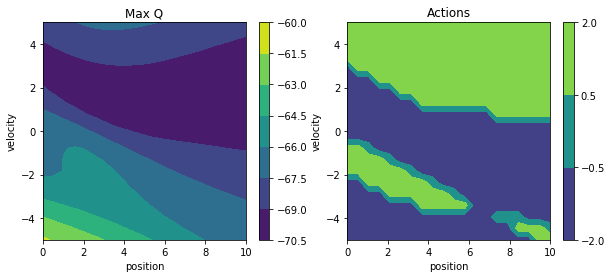

In [10]:
plotFigs(1)

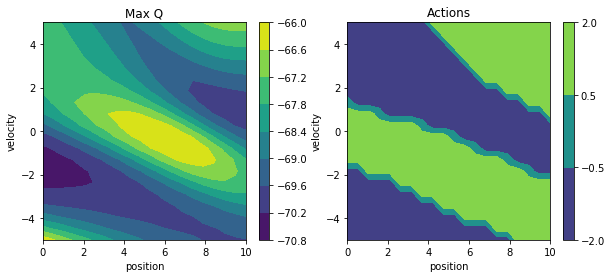

In [11]:
plotFigs(5)

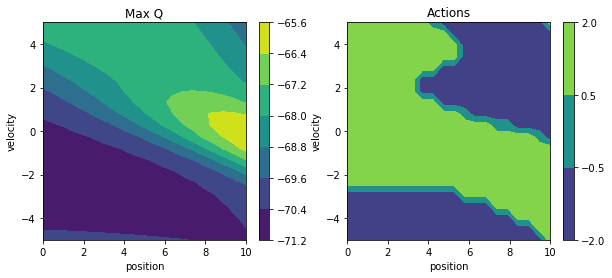

In [12]:
plotFigs(9)

## Decision Making Confidence

Next I wanted to see the confidence with which the network made its decisions. For each position and velocity, these plots show the maximum Q value out of all possible actions divided by the sum of all of these Q values. The idea is to see how the best Q compares to all of the others.

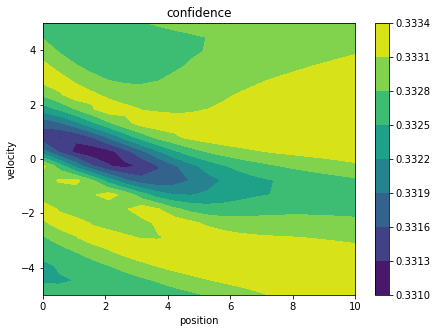

In [13]:
confidencePlot(1)

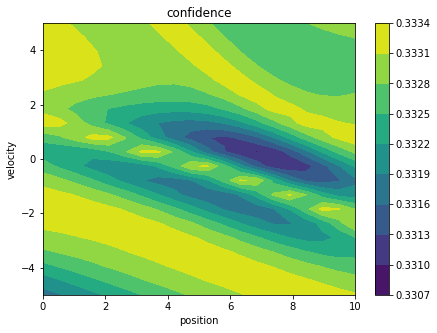

In [14]:
confidencePlot(5)

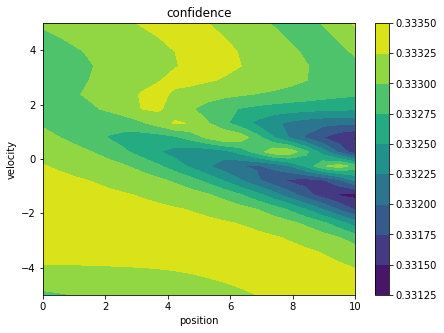

In [15]:
confidencePlot(9)

The plots more or less follow the shape of the Max Q plots above. The areas with the most certainty are the ones in the upper right and lower left. In addition, the network seems to be more certain about which action to take the further the marble is from the goal. What I think is the most interesting is the fact that in every case, the confidence hovers extremely close to 1/3. Since there are only 3 actions possible, this means that in every case, the actions provide almost exactly the same payoff, with only miniscule differences making the decisions. I wonder if this is due to the large number of steps required to reach the goal. My untested hypothesis is that if the acceleration of the marble was greater, the confidence with which the network makes decisions would increase.

## Visualizing the Problem

The final thing I did was to create a visualization of how the marble moves based off of an initial state. So, if you run this next cell, you can see the marble make its way towards the goal of 10 with an inital position of 4 and a velocity of -1 (which means it is moving away from the goal).

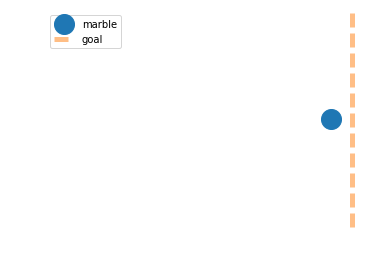

In [16]:
marbleToDestination([4,-1,10])

You can also see what happens when the initial state is not in the set of those generated by the initialState() function. For instance, if the velocity is above 1.5 or below -1.5, the network sometimes makes bizarre decisions. Unfortunately, this is difficult to reproduce consistently, however it happens semi frequently.

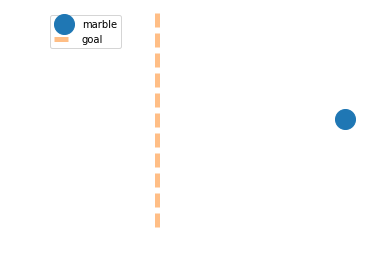

In [17]:
marbleToDestination([6,2,3])

Normally, the only times the marble had to deal with big velocities were when it had accelerated itself to those speeds, which means it is already heading in the right direction. So if you give it a big velocity, it seems that the network has learned its going the right way and won't always turn around. I think this is why you can get weird behaviour with high velocities.

I think this is pretty neat even if it's a little jerky. This was one of the most helpful tools to use when debugging the network. Feel free to play with different input values.

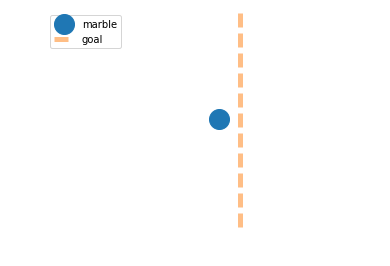

In [18]:
marbleToDestination([5,-2,6])

Thanks for reading!